# Plant Cure

## Background
Plant Cure is a plant disease detection application that aims to automate the identification and diagnosis of diseases affecting plants. This project utilizes the power of deep learning algorithms to analyze images of plants and accurately classify them as healthy or infected with a specific disease.
</p>

## About the dataset

-- Dataset credit: [Kaggle](https://www.kaggle.com/datasets/vipoooool/new-plant-diseases-dataset)

This dataset consists of about 87K rgb images of healthy and diseased crop leaves which is categorized into 38 different classes. The total dataset is divided into 80/20 ratio of training and validation set preserving the directory structure. A new directory containing 33 test images is created later for prediction purpose.

## Approach
A model built using pytorch was developed and tested on standard laptop CPU. Later the core training was offloaded to a GPU on google colab. 

## Performance

```
Train loss: 0.051834, Train acc:98.33267% | Test loss: 0.13384, Test acc: 96.01%
```

# Environment Setup
 
Full list of libraries can be found in the requirements.txt file in the repo

In [2]:
import os
import torch
from torch import nn,optim
from torch.utils.data import Dataset,DataLoader
from torchvision import io
from torchvision import transforms
import pandas as pd
import tqdm
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tqdm
import torchmetrics
import zipfile
import shutil
import pathlib
from PIL import Image

# Data Analysis & Preparation

In [2]:
!tree data/ -L 1

data/
├── test
├── train
├── train_labels.csv
├── valid
└── valid_labels.csv

4 directories, 2 files


The data is organized into 
```
{train|valid}/{classname}/{image_file}.JPG

and

test/{image_file}.JPG
```

## Extract categories and category mappings

In [3]:
# train/test labels
training_data_path = "./data/train/"
training_labels_path = "./data/train_labels.csv"
testing_data_path = "./data/valid/"
testing_labels_path = "./data/valid_labels.csv"

train_labels = []
test_labels = []
categories = {}
index = 0

for dirpath,_,files in os.walk(training_data_path):
    if len(files)>0:
        label_name = os.path.basename(dirpath).split(".")[0]
        if label_name not in categories:
            categories[label_name] = index
            index += 1

reversed_categories = {v:k for k,v in categories.items()}

for dirpath,_,files in os.walk(training_data_path):
    if len(files)>0:
        for f in files:
            path = dirpath+"/"+f
            label_name = os.path.basename(dirpath).split(".")[0]
            label = categories[label_name]
            train_labels.append([path,label])

if not os.path.exists(training_labels_path):
  with open(training_labels_path, 'w', newline='') as csvfile:
      writer = csv.writer(csvfile)
      writer.writerows(train_labels)

for dirpath,_,files in os.walk(testing_data_path):
    if len(files)>0:
        for f in files:
            path = dirpath+"/"+f
            label_name = os.path.basename(dirpath).split(".")[0]
            label = categories[label_name]
            test_labels.append([path,label])

if not os.path.exists(testing_labels_path):
  with open(testing_labels_path, 'w', newline='') as csvfile:
      writer = csv.writer(csvfile)
      writer.writerows(test_labels)

categories

{'Tomato___Late_blight': 0,
 'Corn_(maize)___Common_rust_': 1,
 'Peach___Bacterial_spot': 2,
 'Tomato___Target_Spot': 3,
 'Cherry_(including_sour)___Powdery_mildew': 4,
 'Pepper,_bell___healthy': 5,
 'Orange___Haunglongbing_(Citrus_greening)': 6,
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)': 7,
 'Potato___Late_blight': 8,
 'Soybean___healthy': 9,
 'Grape___Black_rot': 10,
 'Corn_(maize)___Northern_Leaf_Blight': 11,
 'Tomato___Leaf_Mold': 12,
 'Apple___Black_rot': 13,
 'Cherry_(including_sour)___healthy': 14,
 'Grape___Esca_(Black_Measles)': 15,
 'Corn_(maize)___healthy': 16,
 'Raspberry___healthy': 17,
 'Tomato___Spider_mites Two-spotted_spider_mite': 18,
 'Tomato___Bacterial_spot': 19,
 'Potato___healthy': 20,
 'Apple___Cedar_apple_rust': 21,
 'Tomato___Septoria_leaf_spot': 22,
 'Squash___Powdery_mildew': 23,
 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot': 24,
 'Strawberry___Leaf_scorch': 25,
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus': 26,
 'Apple___healthy': 27,
 'Potato___Ear

## Dataset Preparation and Visualizing a few images

In [4]:
class ImageDatasetCustom(Dataset):
    def __init__(self,image_labels,transforms=transforms.ToTensor(),target_transforms=None):
        self.image_labels = pd.read_csv(image_labels)
        self.transforms = transforms
        self.target_transforms = target_transforms
    
    def __len__(self):
        return len(self.image_labels)
    
    def __getitem__(self, idx):
        try:
            image = Image.open(self.image_labels.iloc[idx, 0])
            label = self.image_labels.iloc[idx, 1]
            if self.transforms:
                image = self.transforms(image)
            if image.shape[0] == 1:
                image = torch.cat((image,image,image),dim=0)

            if self.target_transforms:
                label = self.target_transforms(label)
            return image, label
        except Exception as e:
            print(f"Dataset error: {str(e)}, image: {self.image_labels.iloc[idx, 0]}")

image_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dataset = ImageDatasetCustom(training_labels_path,transforms=image_transforms)
                                
test_dataset = ImageDatasetCustom(testing_labels_path,transforms=image_transforms)
print(f"{len(train_dataset)} Training Images")
print(f"{len(test_dataset)} Testing Images")

70294 Training Images
17571 Testing Images


Feature batch shape: torch.Size([5, 3, 256, 256])
Labels batch shape: torch.Size([5])
Image shape: (256, 256, 3)
Image category: Tomato Tomato Yellow Leaf Curl Virus


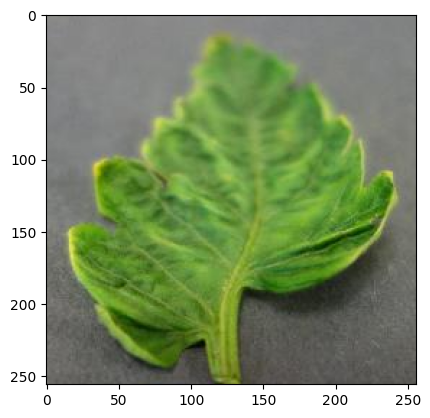

In [5]:
# Explore the dataset
sample_dataset = ImageDatasetCustom(training_labels_path,transforms=transforms.ToTensor())
sample_dataloader = DataLoader(sample_dataset, batch_size=5, shuffle=True)
train_features, train_labels = next(iter(sample_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
image = np.transpose((train_features[0]*256).type(torch.int).numpy(), (1, 2, 0))
print(f"Image shape: {image.shape}")

category = reversed_categories[train_labels[0].item()].replace("___"," ").replace("_"," ").replace(",","")
print(f"Image category: {category}")
plt.imshow(image)
plt.show()

# Model and Hyper params preparation

The model intuition comes from the VGG [paper](https://arxiv.org/pdf/1409.1556.pdf) by Karen Simonyan
∗ & Andrew Zisserman of Oxford University.

The initial design was to mimic the VGG19 setup with 19 convolution layers. However, the full model was found to be very slow and did not learn. With the tradeoff that the full 19 layers resulted in a smaller model(due to reductionist nature of convolutional layers which affects the fc layers), I started by systematically reducing the number of convolutions and fully connected layers and experimenting.

In the end, an architecturally simple but size-wise large model was found to learn and perform in a satisfactory way. It's defined below:

In [6]:
class PlantDiseaseDetector(nn.Module):
    def __init__(self,number_of_classes):
        super().__init__()

        self.cnn = nn.Sequential(
            nn.Conv2d(in_channels=3,out_channels=64,kernel_size=(3,3),stride=(1,1),padding=(1,1)),
            nn.ReLU(),
            nn.Conv2d(in_channels=64,out_channels=64,kernel_size=(3,3),stride=(1,1),padding=(1,1)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2),stride=(2,2)),

            nn.Conv2d(in_channels=64,out_channels=128,kernel_size=(3,3),stride=(1,1),padding=(1,1)),
            nn.ReLU(),
            nn.Conv2d(in_channels=128,out_channels=128,kernel_size=(3,3),stride=(1,1),padding=(1,1)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2),stride=(2,2)),

            nn.Conv2d(in_channels=128,out_channels=256,kernel_size=(3,3),stride=(1,1),padding=(1,1)),
            nn.ReLU(),
            nn.Conv2d(in_channels=256,out_channels=256,kernel_size=(3,3),stride=(1,1),padding=(1,1)),
            nn.ReLU(),
            nn.Conv2d(in_channels=256,out_channels=256,kernel_size=(3,3),stride=(1,1),padding=(1,1)),
            nn.ReLU(),
            nn.Conv2d(in_channels=256,out_channels=256,kernel_size=(3,3),stride=(1,1),padding=(1,1)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2),stride=(2,2)),

        )
        self.flatten = nn.Flatten()
        self.fc = nn.Sequential(
            nn.Linear(in_features=200704,out_features=500),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(in_features=500,out_features=number_of_classes),
        )

    def forward(self,X):
        flattened = self.flatten(self.cnn(X))
        return self.fc(flattened)



## Hyperparams and Optimizer

The choise of the hyperparams was inherited from the original VGG architecture with others determined by the CPU/GPU tradeoff. The final model was trained on a Tesla T4 GPU trained for 15 epochs taking 50 images per batch

In [17]:
NUMBER_OF_CLASSES = len(categories)
EPOCHS = 1
BATCH_SIZE = 1
LEARNING_RATE = 0.001
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_PATH = pathlib.Path("models/plantcure_v003.pt")


model = PlantDiseaseDetector(NUMBER_OF_CLASSES).to(DEVICE)
model.load_state_dict(torch.load(MODEL_PATH,map_location=DEVICE))

optimizer = optim.SGD(model.parameters(),lr=LEARNING_RATE,momentum=0.9)
loss_fn = nn.CrossEntropyLoss()
accuracy_fn = torchmetrics.Accuracy(task="multiclass", num_classes=NUMBER_OF_CLASSES).to(DEVICE)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)
model

PlantDiseaseDetector(
  (cnn): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU()
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (17): ReLU()
    (18): MaxPool2d(ker

# Training the model

In [ ]:
epoch_counts = []
training_losses = []
testing_losses = []
training_accuracies = []
testing_accuracies = []

for epoch in tqdm.tqdm(range(EPOCHS)):
    print(f"\n Epoch {epoch+1}\n----------------------------------")
    epoch_counts.append(epoch)

    # train
    train_loss,train_acc = 0,0
    model.train()
    for batch,(X,y) in enumerate(train_dataloader):
        X = X.to(DEVICE)
        y = y.to(DEVICE)
        train_logits = model(X)
        y_pred = torch.softmax(train_logits,dim=1).argmax(dim=1)
        training_loss = loss_fn(train_logits,y)
        train_acc += accuracy_fn(y_pred,y).item() * 100
        train_loss += training_loss.item()
        optimizer.zero_grad()
        training_loss.backward()
        optimizer.step()

        if (batch+1) % 1 == 0:
            print(f"Looked at {(batch+1) * len(X)}/{len(train_dataloader.dataset)} samples")
            break

    train_loss /= len(train_dataloader)
    train_acc /= len(train_dataloader)
    training_losses.append(train_loss)
    training_accuracies.append(train_acc)

    #test
    model.eval()
    test_loss, test_acc = 0, 0 
    with torch.inference_mode():
        for batch,(X,y) in enumerate(test_dataloader):
            X = X.to(DEVICE)
            y = y.to(DEVICE)
            test_logits = model(X)
            test_loss += loss_fn(test_logits,y).item()
            y_test_pred = torch.softmax(test_logits,dim=1).argmax(dim=1)
            test_acc += accuracy_fn(y_test_pred,y).item() * 100
            break
    
    test_loss /= len(test_dataloader)
    test_acc /= len(test_dataloader)
    testing_losses.append(test_loss)
    testing_accuracies.append(test_acc)

    print(f"\nTrain loss: {train_loss:.6f}, Train acc:{train_acc:.5f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%\n")

# Learning Curves

In [15]:
def plot_learning_curve(epochs,training_values,testing_values,title="Learning Curve",):
    plt.title(title)
    sns.lineplot(x=epochs,y=training_values,color="orange",label="training")
    sns.lineplot(x=epochs,y=testing_values,color="teal",label="validation")

## Loss Curve

Here is the partial loss curve when training on the GPU

!["Partial Loss Curve"](assets/partial_loss_curve.png "Partial Loss Curve")

In [ ]:
# Loss Curve
plot_learning_curve(epoch_counts, training_losses, testing_losses,"Loss vs Epoch")

## Accuracy Curve

Here is the partial accuracy curve when training on the GPU

!["Partial Accuracy Curve"](assets/partial_accuracy_curve.png "Partial Accuracy Curve")

In [ ]:
# Accuracies Curve
plot_learning_curve(epoch_counts, training_accuracies, testing_accuracies,title="Accuracy vs Epoch")

# Saving the model

In [17]:
param_size = 0
for param in model.parameters():
    param_size += param.nelement() * param.element_size()
buffer_size = 0
for buffer in model.buffers():
    buffer_size += buffer.nelement() * buffer.element_size()

size_all_mb = (param_size + buffer_size) / 1024**2
print('model size: {:.3f}MB'.format(size_all_mb))

# !mkdir models
# MODEL_PATH = pathlib.Path("models/plantcure_v1.pt")

# torch.save(model.state_dict(),MODEL_PATH)

model size: 1532.391MB


# Inference

In [63]:
import json

with open("categories.json", "r") as f:
    categories = json.load(f)
reversed_categories = {v:k for k,v in categories.items()}

tensor([24])
Predicted Category: Strawberry Leaf scorch



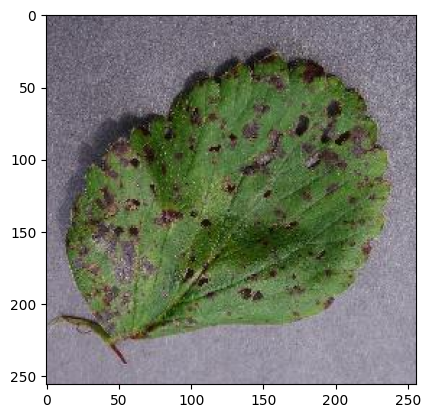

In [64]:
# prepare the model
MODEL_PATH = pathlib.Path("models/plantcure_v003.pt")
NUMBER_OF_CLASSES = len(categories)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
model = PlantDiseaseDetector(NUMBER_OF_CLASSES).to(torch.device("cpu"))
model.load_state_dict(torch.load(MODEL_PATH,map_location=torch.device('cpu')))


image_url = "data/valid/Strawberry___Leaf_scorch/01cff44f-9564-42f7-9a29-3daa487b306a___RS_L.Scorch 1333_flipLR.JPG" # Input
img_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
image = img_transforms(Image.open(image_url)).to(torch.device('cpu')).unsqueeze(dim=0)
# print(categories)

model.eval()
with torch.inference_mode():
    logits = model(image)
    pred_index = torch.softmax(logits,dim=1).argmax(dim=1)
    print(pred_index)
    predicted_category = reversed_categories[pred_index.item()].replace("___"," ").replace("_"," ").replace(",","")
    # print(pred_index.item())
    print(f"Predicted Category: {predicted_category}")

print()
plt.imshow(Image.open(image_url))
plt.show()

In [16]:
import json

with open("categories.json", "r") as f:
    categories = json.load(f)
reversed_categories = {v:k for k,v in categories.items()}

In [19]:
set([k.replace("___"," ").replace("_"," ").replace(",","").lower() for k in categories.keys()])

{'apple apple scab',
 'apple black rot',
 'apple cedar apple rust',
 'apple healthy',
 'blueberry healthy',
 'cherry (including sour) healthy',
 'cherry (including sour) powdery mildew',
 'corn (maize) cercospora leaf spot gray leaf spot',
 'corn (maize) common rust ',
 'corn (maize) healthy',
 'corn (maize) northern leaf blight',
 'grape black rot',
 'grape esca (black measles)',
 'grape healthy',
 'grape leaf blight (isariopsis leaf spot)',
 'orange haunglongbing (citrus greening)',
 'peach bacterial spot',
 'peach healthy',
 'pepper bell bacterial spot',
 'pepper bell healthy',
 'potato early blight',
 'potato healthy',
 'potato late blight',
 'raspberry healthy',
 'soybean healthy',
 'squash powdery mildew',
 'strawberry healthy',
 'strawberry leaf scorch',
 'tomato bacterial spot',
 'tomato early blight',
 'tomato healthy',
 'tomato late blight',
 'tomato leaf mold',
 'tomato septoria leaf spot',
 'tomato spider mites two-spotted spider mite',
 'tomato target spot',
 'tomato tomat

In [7]:
plants = set([k.replace("___"," ").replace("_"," ").replace(",","").split()[0] for k in categories.keys()])
diseases = set([k.replace("___"," ").replace("_"," ").replace(",","").split()[1] for k in categories.keys()])

In [21]:
diseases

{'(including sour) healthy',
 '(including sour) powdery mildew',
 '(maize) cercospora leaf spot gray leaf spot',
 '(maize) common rust',
 '(maize) healthy',
 '(maize) northern leaf blight',
 'bacterial spot',
 'bell bacterial spot',
 'bell healthy',
 'black rot',
 'cedar apple rust',
 'early blight',
 'esca (black measles)',
 'haunglongbing (citrus greening)',
 'healthy',
 'late blight',
 'leaf blight (isariopsis leaf spot)',
 'leaf mold',
 'leaf scorch',
 'mosaic virus',
 'powdery mildew',
 'scab',
 'septoria leaf spot',
 'spider mites two-spotted spider mite',
 'target spot',
 'yellow leaf curl virus'}

In [29]:
diseases = []

for k in categories:
    kl = k.replace("___"," ").replace("_"," ").replace(",","").split()
    if kl[0] == kl[1]:
        diseases.append(" ".join(kl[1:]).lower())
    else:
        diseases.append(" ".join(kl[:]).lower())

In [30]:
set(diseases)

{'apple black rot',
 'apple cedar apple rust',
 'apple healthy',
 'apple scab',
 'blueberry healthy',
 'cherry (including sour) healthy',
 'cherry (including sour) powdery mildew',
 'corn (maize) cercospora leaf spot gray leaf spot',
 'corn (maize) common rust',
 'corn (maize) healthy',
 'corn (maize) northern leaf blight',
 'grape black rot',
 'grape esca (black measles)',
 'grape healthy',
 'grape leaf blight (isariopsis leaf spot)',
 'orange haunglongbing (citrus greening)',
 'peach bacterial spot',
 'peach healthy',
 'pepper bell bacterial spot',
 'pepper bell healthy',
 'potato early blight',
 'potato healthy',
 'potato late blight',
 'raspberry healthy',
 'soybean healthy',
 'squash powdery mildew',
 'strawberry healthy',
 'strawberry leaf scorch',
 'tomato bacterial spot',
 'tomato early blight',
 'tomato healthy',
 'tomato late blight',
 'tomato leaf mold',
 'tomato mosaic virus',
 'tomato septoria leaf spot',
 'tomato spider mites two-spotted spider mite',
 'tomato target spot